In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.cuda.amp as amp
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import DistilBertModel, DistilBertTokenizerFast, get_linear_schedule_with_warmup
from datasets import Dataset
from tqdm import tqdm

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_and_prepare_data(csv_path):
    df = pd.read_csv(csv_path)

    status_map = {
        0: 'accepted', 1: 'accepted', 2: 'accepted',
        3: 'pending', 4: 'pending',
        5: 'blocked', 6: 'blocked', 7: 'blocked'
    }
    df['Decision'] = df['Status'].map(status_map)
    df = df.dropna(subset=['Text'])
    df['Text'] = df['Text'].astype(str)

    label_enc = LabelEncoder()
    status_enc = LabelEncoder()
    df['label_encoded'] = label_enc.fit_transform(df['Label'])
    df['status_encoded'] = status_enc.fit_transform(df['Status'])

    # Option 1: Simple stratification (just by label)
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42, 
        stratify=df['label_encoded']  # Stratify only by label
    )
    
    # Option 2: If you really need to stratify by both, first check and remove rare combinations
    # Get counts of each label-status combination
    # combo_counts = df.groupby(['label_encoded', 'status_encoded']).size()
    # rare_combos = combo_counts[combo_counts < 2].index
    # Filter out rare combinations
    # df = df[~df.set_index(['label_encoded', 'status_encoded']).index.isin(rare_combos)]
    # Then stratify by both columns

    return train_df, val_df, label_enc, status_enc, status_map

In [3]:
def tokenize_dataset(df, tokenizer):
    def preprocess(example):
        tokens = tokenizer(
            example['Text'], 
            truncation=True, 
            padding='max_length', 
            max_length=128,
            return_tensors='pt'  # Return PyTorch tensors directly
        )
        tokens['labels'] = example['label_encoded']
        tokens['statuses'] = example['status_encoded']
        return tokens

    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(preprocess, batched=True, batch_size=32)  # Batched processing for efficiency
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'statuses'])
    return dataset

In [4]:
class ChatModerationModel(nn.Module):
    def __init__(self, num_labels, num_statuses):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
        # Freeze first 3 transformer layers
        for layer in self.bert.transformer.layer[:3]:
            for param in layer.parameters():
                param.requires_grad = False
                
        self.dropout = nn.Dropout(0.6)  # Increased dropout
        self.label_head = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),  # Additional dropout
            nn.Linear(256, num_labels)
        )
        self.status_head = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),  # Additional dropout
            nn.Linear(256, num_statuses)
        )

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(out.last_hidden_state[:, 0])
        return self.label_head(pooled), self.status_head(pooled)

In [ ]:

def train_model(model, train_loader, val_loader, label_enc, status_enc, status_map, device, epochs=10):
    # Reduced learning rate with more weight decay
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  
    
    # Gradient clipping
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0.1 * len(train_loader), 
        num_training_steps=epochs * len(train_loader)
    )
    loss_fn = nn.CrossEntropyLoss()
    scaler = amp.GradScaler()
    best_loss = float('inf')
    patience = 3  # Increased patience
    counter = 0

    history = {'train_loss': [], 'val_loss': [], 'val_label_acc': [], 'val_status_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ['labels', 'statuses']}
            labels = batch['labels'].to(device)
            statuses = batch['statuses'].to(device)

            optimizer.zero_grad()
            
            with amp.autocast():
                pred_labels, pred_statuses = model(**inputs)
                loss = 0.7 * loss_fn(pred_labels, labels) + 0.3 * loss_fn(pred_statuses, statuses)  # Weighted loss

            scaler.scale(loss).backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()

        history['train_loss'].append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss, correct_labels, correct_statuses, total = 0, 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k not in ['labels', 'statuses']}
                labels = batch['labels'].to(device)
                statuses = batch['statuses'].to(device)

                logits_label, logits_status = model(**inputs)
                val_loss += (0.7 * loss_fn(logits_label, labels) + 0.3 * loss_fn(logits_status, statuses)).item()

                preds_label = logits_label.argmax(dim=1)
                preds_status = logits_status.argmax(dim=1)
                correct_labels += (preds_label == labels).sum().item()
                correct_statuses += (preds_status == statuses).sum().item()
                total += labels.size(0)

        val_acc_l = correct_labels / total
        val_acc_s = correct_statuses / total
        val_avg_loss = val_loss / len(val_loader)

        history['val_loss'].append(val_avg_loss)
        history['val_label_acc'].append(val_acc_l)
        history['val_status_acc'].append(val_acc_s)

        print(f"Epoch {epoch+1}: Val Loss = {val_avg_loss:.4f}, Label Acc = {val_acc_l:.2%}, Status Acc = {val_acc_s:.2%}")

        if val_avg_loss < best_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            best_loss = val_avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    return history

In [6]:
def plot_training_history(train_losses, val_losses, val_label_acc, val_status_acc):
    """
    Plots training/validation loss and validation accuracies for label and status.
    """
    # Loss curves
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy curves
    plt.figure()
    plt.plot(val_label_acc, label='Val Label Acc')
    plt.plot(val_status_acc, label='Val Status Acc')
    plt.title('Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [7]:
def predict(text, model, tokenizer, label_enc, status_enc, status_map, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits_label, logits_status = model(**inputs)
    label_pred = logits_label.argmax(dim=1).item()
    status_pred = logits_status.argmax(dim=1).item()

    print(f"Text: {text}")
    print(f"→ Label: {label_enc.inverse_transform([label_pred])[0]}")
    print(f"→ Status: {status_enc.inverse_transform([status_pred])[0]}")
    print(f"→ Decision: {status_map[status_pred]}")


Map: 100%|██████████| 601023/601023 [01:25<00:00, 7045.59 examples/s]
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_4540\2547685972.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Training Epoch 1:   0%|          | 0/150256 [00:00<?, ?it/s]C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_4540\2547685972.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training Epoch 1: 100%|██████████| 150256/150256 [1:55:41<00:00, 21.65it/s] 


Epoch 1: Val Loss = 0.6460, Label Acc = 78.99%, Status Acc = 79.92%


Training Epoch 2: 100%|██████████| 150256/150256 [1:47:54<00:00, 23.21it/s]


Epoch 2: Val Loss = 0.5602, Label Acc = 81.42%, Status Acc = 83.08%


Training Epoch 3: 100%|██████████| 150256/150256 [1:47:31<00:00, 23.29it/s]


Epoch 3: Val Loss = 0.5172, Label Acc = 82.60%, Status Acc = 84.58%


Training Epoch 4: 100%|██████████| 150256/150256 [1:48:00<00:00, 23.19it/s]


Epoch 4: Val Loss = 0.4924, Label Acc = 83.26%, Status Acc = 85.41%


Training Epoch 5: 100%|██████████| 150256/150256 [1:54:06<00:00, 21.95it/s]


Epoch 5: Val Loss = 0.4795, Label Acc = 83.63%, Status Acc = 85.95%


Training Epoch 6: 100%|██████████| 150256/150256 [1:52:42<00:00, 22.22it/s] 


Epoch 6: Val Loss = 0.4717, Label Acc = 83.84%, Status Acc = 86.30%


Training Epoch 7: 100%|██████████| 150256/150256 [1:49:53<00:00, 22.79it/s]


Epoch 7: Val Loss = 0.4661, Label Acc = 83.99%, Status Acc = 86.54%


Training Epoch 8: 100%|██████████| 150256/150256 [1:58:00<00:00, 21.22it/s] 


Epoch 8: Val Loss = 0.4589, Label Acc = 84.18%, Status Acc = 86.74%


Training Epoch 9: 100%|██████████| 150256/150256 [1:51:58<00:00, 22.37it/s] 


Epoch 9: Val Loss = 0.4575, Label Acc = 84.21%, Status Acc = 86.92%


Training Epoch 10: 100%|██████████| 150256/150256 [1:51:53<00:00, 22.38it/s] 


Epoch 10: Val Loss = 0.4565, Label Acc = 84.28%, Status Acc = 86.96%


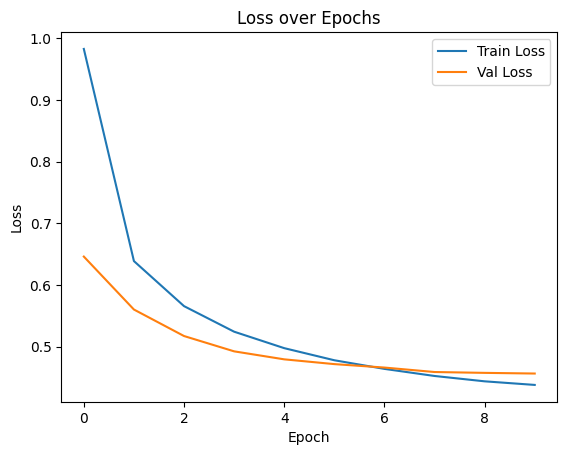

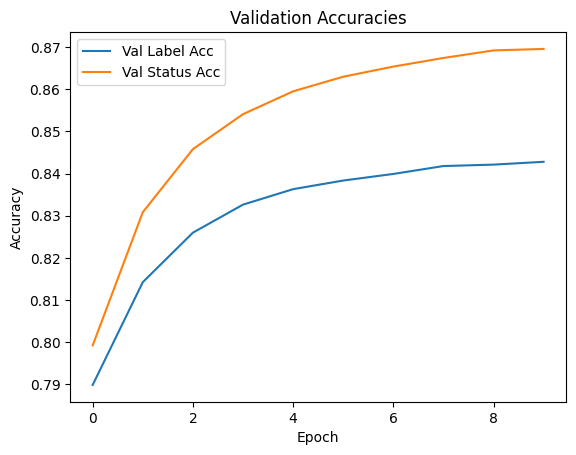

Text: Stop this nonsense now!
→ Label: Nothing Wrong
→ Status: 0
→ Decision: accepted


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_df, val_df, label_enc, status_enc, status_map = load_and_prepare_data(r"U:\N\final1_csv.csv")

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_dataset = tokenize_dataset(train_df, tokenizer)
val_dataset = tokenize_dataset(val_df, tokenizer)

# Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

model = ChatModerationModel(len(label_enc.classes_), len(status_enc.classes_)).to(device)
history = train_model(model, train_loader, val_loader, label_enc, status_enc, status_map, device, epochs=10)

# Plot loss and accuracy
plot_training_history(history['train_loss'], history['val_loss'], history['val_label_acc'], history['val_status_acc'])

# Predict example
model.load_state_dict(torch.load('best_model.pt'))
predict("Stop this nonsense now!", model, tokenizer, label_enc, status_enc, status_map, device)


In [ ]:
predict("", model, tokenizer, label_enc, status_enc, status_map, device)

Text: f u
→ Label: Vulgar
→ Status: 6
→ Decision: blocked


In [10]:
import os, joblib

save_dir = r"U:\N\save"
os.makedirs(save_dir, exist_ok=True)

# 1) Save state_dict (weights)
torch.save(model.state_dict(), os.path.join(save_dir, "model_state.pt"))

# 2) Save the tokenizer (this part was fine)
tokenizer.save_pretrained(save_dir)

# 3) Save your encoders
joblib.dump(label_enc,  os.path.join(save_dir, "label_encoder.pkl"))
joblib.dump(status_enc, os.path.join(save_dir, "status_encoder.pkl"))

print(f"✅ All saved to {save_dir}")


✅ All saved to U:\N\save
